In [1]:
#%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from matplotlib.ticker import FormatStrFormatter
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
from sklearn.linear_model import LinearRegression

InteractiveShell.ast_node_interactivity = "all"

# Loading reported and synthetic data

In [3]:
# Revoking stored reported data
# https://ipython.org/ipython-doc/rel-0.12/config/extensions/storemagic.html

%store -r data_Averoy
%store -r data_Tingvoll
%store -r data_Surnadal
%store -r data_Sunndal
%store -r data_Vestnes
%store -r data_Laerdal

In [4]:
# Revoking top hits frames created by the seen deer estimator
save_dir = "synthetic_data/"
# With option for emigration
top_hits_Averoy_seen_deer = pd.read_pickle(save_dir + "top_hits_Averoy_seen_deer.pkl")
top_hits_Tingvoll_seen_deer = pd.read_pickle(
    save_dir + "top_hits_Tingvoll_seen_deer.pkl"
)
top_hits_Surnadal_seen_deer = pd.read_pickle(
    save_dir + "top_hits_Surnadal_seen_deer.pkl"
)
top_hits_Sunndal_seen_deer = pd.read_pickle(save_dir + "top_hits_Sunndal_seen_deer.pkl")
top_hits_Vestnes_seen_deer = pd.read_pickle(save_dir + "top_hits_Vestnes_seen_deer.pkl")
top_hits_Laerdal_seen_deer = pd.read_pickle(save_dir + "top_hits_Laerdal_seen_deer.pkl")

In [5]:
# Data needed for plotting the figures below
compare = "before_hunt"
municipalities = ["Averoy", "Tingvoll", "Surnadal", "Sunndal", "Vestnes", "Laerdal"]
data_municipality = [
    data_Averoy,
    data_Tingvoll,
    data_Surnadal,
    data_Sunndal,
    data_Vestnes,
    data_Laerdal,
]
top_hits_seen_deer = [
    top_hits_Averoy_seen_deer,
    top_hits_Tingvoll_seen_deer,
    top_hits_Surnadal_seen_deer,
    top_hits_Sunndal_seen_deer,
    top_hits_Vestnes_seen_deer,
    top_hits_Laerdal_seen_deer,
]

afont = {"fontname": "Arial"}

# Figure 7 - spread of the initial population structure figures

In [6]:
#Find all fraction values used originally
initial_population = 1000
initial_hinds_per_stag = np.arange(1.3, 2.1, 0.1)
init_frac_calves = np.arange(0.2, 0.355, 0.01)
init_frac_y_hinds = np.arange(0.09, 0.275, 0.01)  # of total number hinds
init_frac_y_stags = np.arange(0.18, 0.545, 0.02)  # of total number stags

all_initial_states = np.array(
    np.meshgrid(
        initial_population,
        initial_hinds_per_stag,
        init_frac_calves,
        init_frac_y_hinds,
        init_frac_y_stags,
    )
).T.reshape(-1, 5)

In [7]:
def calculate_initial_size_of_each_category(population_data):
    # Using a revised version of the original initial structure generator
    total_number_calves = population_data[0] * population_data[2]
    total_number_adults = population_data[0] * (1 - population_data[2])
    total_number_stags = total_number_adults / (population_data[1] + 1)
    total_number_hinds = total_number_adults - total_number_stags

    female_calves_survivors = total_number_calves / 2
    male_calves_survivors = total_number_calves / 2

    young_hinds_survivors = total_number_hinds * population_data[3]
    adult_hinds_survivors = total_number_hinds - young_hinds_survivors

    young_stags_survivors = total_number_stags * population_data[4]
    adult_stags_survivors = total_number_stags - young_stags_survivors
    return (
        female_calves_survivors,
        young_hinds_survivors,
        adult_hinds_survivors,
        male_calves_survivors,
        young_stags_survivors,
        adult_stags_survivors,
    )

In [8]:
# Find the min and max fraction values for all six categories
number_category = np.zeros((all_initial_states.shape[0],6))
fraction_category = np.zeros((all_initial_states.shape[0],6))
for i in range(all_initial_states.shape[0]):
    number_category[i,:] = calculate_initial_size_of_each_category(all_initial_states[i,:])
    fraction_category[i,:] = number_category[i,:] / all_initial_states[i,0]
fraction_category.shape
min_fraction = np.min(fraction_category, axis=0)
max_fraction = np.max(fraction_category, axis=0)

(46208, 6)

In [9]:
def plot_init_pop_structure():
    fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12,8))
    init_fractions = np.zeros((20,6))
    municipalities = ["Averøy   ","Tingvoll   ", "Surnadal   ", "Sunndal   ", "Vestnes   ", "Lærdal   "]
    counter = 0
    for q in range(3):
        for j in range(2):
            # Extract all 6 targeted parameters associated with the top hit and make fraction
            parameters = top_hits_seen_deer[counter].iloc[:,3:9].values
            init_pop = top_hits_seen_deer[counter].iloc[:,0].values
            for i in range(len(top_hits_seen_deer[counter])):
                init_fractions[i,:] = parameters[i,:] / init_pop[i]
            
            # Adding normalized init_pop to the above array
            mean_init_pop = np.mean(init_pop)
            min_init_pop = 900 * (0.25 / mean_init_pop)
            scaled_min_fraction = np.insert(min_fraction, 0, min_init_pop)
            max_init_pop = 4000 * (0.25 / mean_init_pop)
            scaled_max_fraction = np.insert(max_fraction, 0, max_init_pop)
            
            init_pop_scaled = init_pop * (0.25 / mean_init_pop)
            init_fractions_new = np.c_[init_pop_scaled, init_fractions]
            
            y = np.arange(1,8)
            ax[q,j].boxplot(init_fractions_new[:][:])
            ax[q,j].plot(y,scaled_min_fraction,'b*')
            ax[q,j].plot(y,scaled_max_fraction,'r*')
            ax[q,j].margins(x=0.01)
            
            no_text = [""] * 7
            if (counter != 4) & (counter != 5):
                ax[q,j].set_xticks(y)
                ax[q,j].set_xticklabels(no_text)
            else:
                ax[q,j].set_xticks(y)
                ax[q,j].set_xticklabels(["init_pop", "f_calves", "y_hinds", "a_hinds", "m_calves", "y_stags", "a_stags"], rotation="vertical", fontsize=12, **afont)
            if (counter == 0) | (counter == 2) | (counter == 4):
                ax[q,j].set_ylabel("Initial population fractions", fontsize=12, **afont)
            ax[q,j].set_title(municipalities[counter], y=0.8, loc="right", fontsize=14, **afont)
            counter = counter + 1
    fig.tight_layout()
    save_dir = "figures/"
    plt.savefig(save_dir + "Figure_7.pdf", dpi=600, bbox_inches="tight")
    pass;
    return

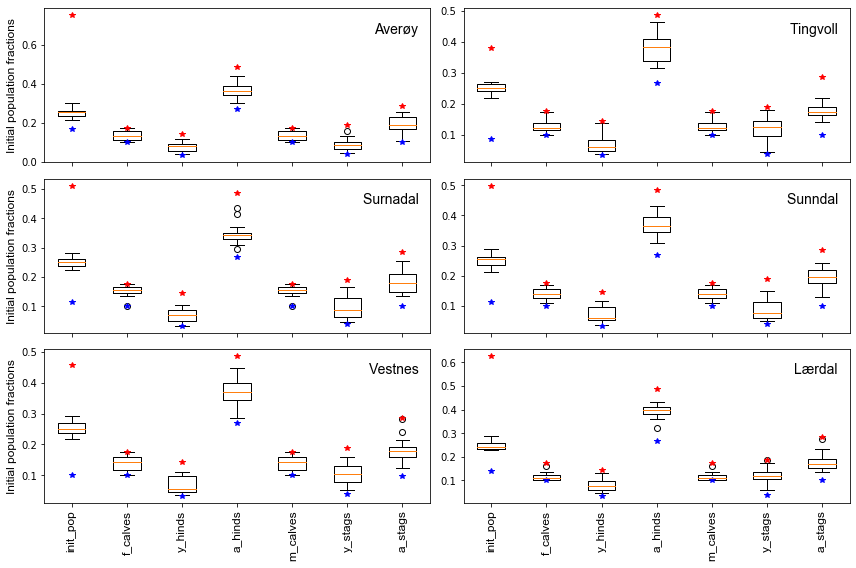

In [10]:
plot_init_pop_structure()

# Calculating explained variance in tot_pop_ah by initial conditions

In [11]:
q = 0
for municipality in municipalities:
    X = top_hits_seen_deer[q][['init_pop']]
    y = top_hits_seen_deer[q]['tot_pop_ah']
    model = LinearRegression().fit(X,y)
    r_sq = model.score(X,y)
    print("Explained variance by init_pop:",r_sq, " - ", municipality)
    print()
    
    X = top_hits_seen_deer[q][['init_pop', 'i_fcalves', 'i_yhinds', 'i_ahinds', 'i_mcalves', 'i_ystags', 'i_astags']]
    y = top_hits_seen_deer[q]['tot_pop_ah']
    model = LinearRegression().fit(X,y)
    r_sq = model.score(X,y)
    print("Explained variance by [init_pop, i_fcalves, i_yhinds, i_ahinds, i_mcalves, i_ystags, i_astags] : ",r_sq, " - ", municipality)
    print()
    print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
    print()
    q = q + 1

Explained variance by init_pop: 0.31553714130709565  -  Averoy

Explained variance by [init_pop, i_fcalves, i_yhinds, i_ahinds, i_mcalves, i_ystags, i_astags] :  0.5438812053638615  -  Averoy

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Explained variance by init_pop: 0.1331952759595253  -  Tingvoll

Explained variance by [init_pop, i_fcalves, i_yhinds, i_ahinds, i_mcalves, i_ystags, i_astags] :  0.3503434165898125  -  Tingvoll

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Explained variance by init_pop: 0.01801329142480035  -  Surnadal

Explained variance by [init_pop, i_fcalves, i_yhinds, i_ahinds, i_mcalves, i_ystags, i_astags] :  0.2498131516047546  -  Surnadal

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Explained variance by init_pop: 0.33947997976964917  -  Sunndal

Explained variance by [init_pop, i_fcalves, i_yhinds, i_ahinds, i_mcalves, i_ystags, i_astags] :  0.4894660332033154  -  Sunndal

@@@@@@@@@@@@@@@